In [1]:
import math
import torch
import gpytorch
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

In [2]:
import sklearn.metrics as sk

### Fully supervised GPLVM (we should come up with a better acronym/name)

Observations:
$$Y = [y_1,...,y_N], \ y_n \in R^{p}$$
Model parameters
$$X = [x_1,...,x_N], \ x_n \in R^{p\times q}$$
Latent parameters/features
$$L = [l_1,...,l_N], \ l_n \in R^{d }$$
With $d<q$ and $L\sim N(0,I)$.

We want to find a function $f_\theta$ such that:
$$ Y = f_\theta(X,L)+\epsilon $$
Let's make $f$ a GP, as we like to, with mean $m_\theta(X,L)$ and covariance $K_\theta((X,L),(X',L'))$
We would like to learn $L$ and $\theta$ (the hyper-parameters). 

As a cost function we use the likelihood
$$p(Y,L|X) = p(Y|L,X)p(L) $$
and as $f$ is a GP,
$$p(Y|L,X) \sim N(m_\theta(X,L), K_\theta((X,L),(X,L)))$$

Taking the log we have
$$\log p(Y,L|X) = \log p(Y|L,X)+\log p(L) $$
$$ = -\frac{NP}{2}\log(2\pi)-\frac{1}{2}\log|K_\theta|-\frac{1}{2}(Y-m_\theta(X,L))^\top\ K_\theta^{-1}(Y-m_\theta(X,L))-\frac{N*LDIM}{2}\log(2\pi)-\frac{1}{2}\log|I|-\frac{1}{2}(L)^\top I^{-1}(L)) $$


to calculate $\log |K|$ we use the fact that $\log |K| = 2\Sigma (\log\mathrm{diag}(L)_i)$, where $L$ is the cholesky decomposition of $K$.

In [3]:
def multivariate_ll(y,mu,K,K_inv=None):
    det = 2*torch.sum(torch.log(torch.diag(torch.linalg.cholesky(K))))
    if K_inv==None:
        ll = -((y.shape[0]*y.shape[1])/2)*torch.log(2*torch.tensor(torch.pi))-0.5*y.shape[1]*det-0.5*torch.sum(torch.diag(torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))))
        #ll = -(y.shape[0]/2)*torch.log(2*torch.tensor(torch.pi))-0.5*det-0.5*torch.matmul((y-mu).T,torch.linalg.solve(K,y-mu))
        
    return ll

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel



def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X1=X1/torch.sqrt(lengthscale)
    X2=X2/torch.sqrt(lengthscale)
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf(X1,L1,X2,L2,scaling,lengthscale,p1,p2):
    X_1 = (torch.cat((X1,torch.repeat_interleave(L1,p1,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (torch.cat((X2,torch.repeat_interleave(L2,p2,dim=0)),axis=1)/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf

def rbf2(X1,X2,scaling,lengthscale):

    X_1 = (X1/torch.sqrt(lengthscale)).detach().numpy()
    X_2 = (X2/torch.sqrt(lengthscale)).detach().numpy()
    rbf = scaling * torch.tensor(rbf_kernel(X_1,X_2, gamma = 1))

    return rbf


def rbf(X1,X2,scaling,lengthscale):

    X_1 = X1/lengthscale
    X_2 = X2/lengthscale
    rbf = scaling * torch.exp(-0.5*torch.cdist(X_1,X_2,p=2)**2)

    return rbf



For the linear kernel we don't really have any separation possibilities that are useful to us from an inverting persepctive, as far as I can tell? 
$$K_{ij}=x_i^\top x_j + l_i^\top l_j$$

So we don't get much in the way of help here.

In [5]:
def linear(X1,L1,X2,L2,X_length,L_length,p1,p2):
    
    L1=L1/torch.sqrt(L_scale)
    X1=X1/torch.sqrt(X_scale)
    X_1 = torch.cat((X1,torch.repeat_interleave(L1,p1)[:,None]),axis=1)

    L2=L2/torch.sqrt(L_scale)
    X2=X2/torch.sqrt(X_scale)
    X_2 = torch.cat((X2,torch.repeat_interleave(L2,p2)[:,None]),axis=1)
    
    rbf =  torch.matmul(X_1, X_2.T) 
    return rbf

sample $L$ and $X$ from $U[-1,1]$

Here we do $x_i \neq x_j$, just for the sake of it

Posterior mean: $$m(X^*,X)+K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I)^{-1}(Y-m(X,X))$$

Posterior covar: $$K((X^*,L^*),(X^*,L^*))+\sigma^2 - K((X^*,L^*),(X,L))(K((X,L),(X,L))+\sigma^2I]^{-1}K((X^*,L^*),(X,L))^\top$$

In [6]:
def posterior_theta(Y,X_test,L_test,p_test,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,L_train,X_train,L_train,scaling,lengthscale,p_train,p_train)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,L_test,X_train,L_train,scaling,lengthscale,p_test,p_train)
    K_ss = rbf(X_test,L_test,X_test,L_test,scaling,lengthscale,p_test,p_test)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

In [7]:
def posterior_theta(Y,X_test,X_train,scaling,lengthscale,sigma2,mean):
    K = rbf(X_train,X_train,scaling,lengthscale)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf(X_test,X_train,scaling,lengthscale)
    K_ss = rbf(X_test,X_test,scaling,lengthscale)

    mean_p = mean+torch.matmul(K_s,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s,torch.linalg.solve(K,K_s.T))+sigma2
    return mean_p, K_p

### Test 1

In [8]:
N = 10 #number of systems
p = 20 #observations per system
alpha=10
beta=-7
zeta=1

In [9]:
L_true=torch.FloatTensor(N, 1).uniform_(1, 4)
L_true =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1]))

In [10]:
L_true

tensor([[-1.8108],
        [ 0.9042],
        [-2.1659],
        [ 0.9273],
        [-0.2215],
        [ 0.5312],
        [ 1.3319],
        [ 1.0924],
        [ 0.1696],
        [ 0.0916]])

In [11]:
multivariate_ll(L_true,0,torch.eye(N),K_inv=None)

tensor(-15.6809)

In [12]:

import scipy
np.sum(scipy.stats.multivariate_normal.logpdf(L_true.T.detach().numpy(),cov=np.eye(N)))

-15.680945930797659

In [13]:
X_train=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)
X_test=torch.torch.FloatTensor(N*p, 1).uniform_(-2, 2)

In [14]:
L_true[[0]][0]

tensor([-1.8108])

In [15]:
def true_func(X,L,alpha,beta,zeta):
    tf = alpha*X*X+L*beta+torch.normal(0,0.0001*torch.ones(X.shape[0],1))
    return tf

In [16]:
lmin=-2
lmax=2

xmin=-2
xmax=2


l_range = torch.linspace(lmin,lmax,100)
x_range = torch.linspace(xmin,xmax,100)

XX,LL  = torch.meshgrid(l_range,x_range)
XXLL = torch.cat([XX.reshape(10000,1),LL.reshape(10000,1)],axis=1)

YY = true_func(XX,LL,alpha,beta,zeta)

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


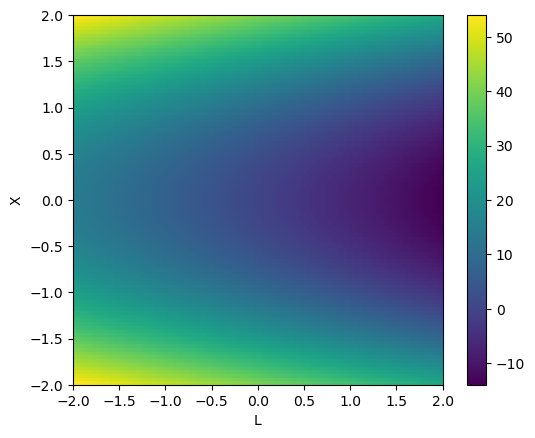

In [17]:
plt.imshow(YY,origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.ylabel('X')
plt.xlabel('L')

plt.colorbar()

In [18]:
y=[]
y_test = []
for i in range(N):
    y.append(true_func(X_train[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))
    y_test.append(true_func(X_test[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))

In [19]:
Y=torch.cat(y)
Y_test=torch.cat(y_test)

In [20]:
Y.shape

torch.Size([200, 1])

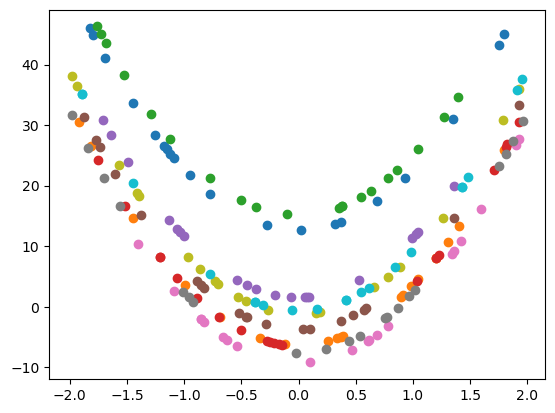

In [21]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0].detach().numpy(),Y[i*p:(i+1)*p].detach().numpy(),'o')

In [22]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X_train.mean()
X_std =X_train.std()

X_train = (X_train-X_mean)/X_std
X_test = (X_test-X_mean)/X_std

Y=(Y-Y_mean)/Y_std
Y_test=(Y_test-Y_mean)/Y_std

In [23]:
X_all_train = (torch.cat((X_train,torch.repeat_interleave(L_true,p,dim=0)),axis=1))
X_all_test = (torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1))


In [24]:
emulator=GPE.ensemble(X_all_train,Y,mean_func='zero',training_iter=1000)

0


In [25]:
for param_name, param in emulator.models[0].named_parameters():
    print(f'Parameter name: {param_name:42} ')

Parameter name: likelihood.noise_covar.raw_noise           
Parameter name: covar_module.raw_outputscale               
Parameter name: covar_module.base_kernel.raw_lengthscale   


In [26]:
emulator.models[0].covar_module.outputscale
emulator.models[0].covar_module.base_kernel.lengthscale

tensor([[ 3.0082, 24.8837]], grad_fn=<SoftplusBackward0>)

In [27]:
emulator.models[0].covar_module.outputscale.detach().clone()

tensor(48.8181)

In [28]:
rbf(X_all_train,X_all_train,1.,torch.tensor(1.))

tensor([[1.0000, 0.4383, 0.9924,  ..., 0.0051, 0.0892, 0.1558],
        [0.4383, 1.0000, 0.5095,  ..., 0.0660, 0.1611, 0.0456],
        [0.9924, 0.5095, 1.0000,  ..., 0.0070, 0.1014, 0.1488],
        ...,
        [0.0051, 0.0660, 0.0070,  ..., 1.0000, 0.3103, 0.0130],
        [0.0892, 0.1611, 0.1014,  ..., 0.3103, 1.0000, 0.3662],
        [0.1558, 0.0456, 0.1488,  ..., 0.0130, 0.3662, 1.0000]])

In [29]:
rbf(X_all_train,X_all_train,1.,torch.tensor(1.))-rbf2(X_all_train,X_all_train,1.,torch.tensor(1.))

tensor([[0.0000, 0.2462, 0.0075,  ..., 0.0051, 0.0812, 0.1315],
        [0.2462, 0.0000, 0.2499,  ..., 0.0617, 0.1351, 0.0435],
        [0.0075, 0.2499, 0.0000,  ..., 0.0070, 0.0911, 0.1266],
        ...,
        [0.0051, 0.0617, 0.0070,  ..., 0.0000, 0.2140, 0.0128],
        [0.0812, 0.1351, 0.0911,  ..., 0.2140, 0.0000, 0.2321],
        [0.1315, 0.0435, 0.1266,  ..., 0.0128, 0.2321, 0.0000]])

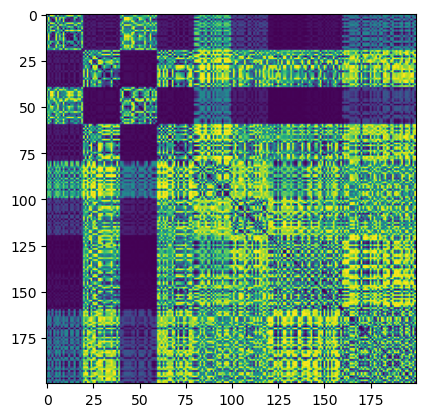

In [30]:
plt.imshow(rbf(X_all_train,X_all_train,1.,torch.tensor(1.))-rbf2(X_all_train,X_all_train,1.,torch.tensor(1.)))

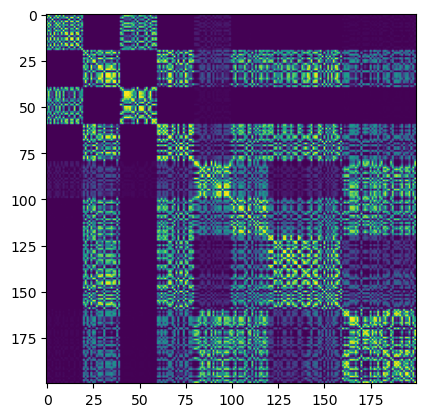

In [31]:
plt.imshow(rbf2(X_all_train,X_all_train,1.,torch.tensor(1.)))

In [32]:
emulator.R2(X_all_test,Y_test)

tensor([1.0000], grad_fn=<RsubBackward1>)

In [33]:
def cost(y,XL,scaling,lengthscale,sigma2,L_dim,mean=0):
    
    K=rbf(XL,XL,scaling,lengthscale)+sigma2*torch.eye(XL.shape[0])
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(y,mean,K) + multivariate_ll(XL[:,L_dim:],0,torch.eye(XL.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    return -c

In [34]:
L = torch.rand(L_true.shape[0],L_true.shape[1]).clone().detach().requires_grad_(True)

In [46]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
L_orig = L.clone().detach()
#L =L_true.clone().detach().requires_grad_(True)
scaling = torch.rand(1).clone().detach().requires_grad_(True)

lengthscale = (torch.rand(X_train.shape[1]+L_true.shape[1])).clone().detach().requires_grad_(True)

lengthscale = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)
lengthscale_in=torch.tensor([lengthscale[0],4])






scaling_true = emulator.models[0].covar_module.outputscale.detach().clone().requires_grad_(True)#torch.rand(1).clone().detach().requires_grad_(True)

lengthscale_true = torch.rand(X_train.shape[1]).clone().detach().requires_grad_(True)


lengthscale_true = emulator.models[0].covar_module.base_kernel.lengthscale.detach().clone().requires_grad_(True) #torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)

#lengthscale=lengthscale_true.clone().detach().requires_grad_(True)
#scaling=scaling_true.clone().detach().requires_grad_(True)

sigma2 = torch.tensor([0.0001]).clone().detach().requires_grad_(True)
mean = torch.rand(1).clone().detach().requires_grad_(True)
mean=0

In [47]:
XL_test = torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1)
XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)

XL_true_test = torch.cat((X_test,torch.repeat_interleave(L_true,p,dim=0)),axis=1)
XL_true_train = torch.cat((X_train,torch.repeat_interleave(L_true,p,dim=0)),axis=1)

In [48]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

tensor([-6.4530], grad_fn=<RsubBackward1>) tensor([1070.5198], grad_fn=<MeanBackward1>) tensor([143.6352])
tensor([0.6335], grad_fn=<RsubBackward1>) tensor([46.9048], grad_fn=<MeanBackward1>) tensor([127.9830])
tensor([-1.6626], grad_fn=<RsubBackward1>) tensor([493.6039], grad_fn=<MeanBackward1>) tensor([185.3810])
tensor([0.5719], grad_fn=<RsubBackward1>) tensor([50.5419], grad_fn=<MeanBackward1>) tensor([118.0634])
tensor([-4.8209], grad_fn=<RsubBackward1>) tensor([817.6093], grad_fn=<MeanBackward1>) tensor([140.4617])
tensor([0.9481], grad_fn=<RsubBackward1>) tensor([4.4946], grad_fn=<MeanBackward1>) tensor([86.5942])
tensor([-2.1772], grad_fn=<RsubBackward1>) tensor([348.8533], grad_fn=<MeanBackward1>) tensor([109.8006])
tensor([0.9752], grad_fn=<RsubBackward1>) tensor([4.4276], grad_fn=<MeanBackward1>) tensor([178.8721])
tensor([0.8391], grad_fn=<RsubBackward1>) tensor([25.9263], grad_fn=<MeanBackward1>) tensor([161.1512])
tensor([-0.2417], grad_fn=<RsubBackward1>) tensor([166.654

In [49]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_true_test[i*p:(i+1)*p],XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0005], grad_fn=<MeanBackward1>) tensor([143.6352])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0004], grad_fn=<MeanBackward1>) tensor([127.9830])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0030], grad_fn=<MeanBackward1>) tensor([185.3810])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0002], grad_fn=<MeanBackward1>) tensor([118.0634])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0004], grad_fn=<MeanBackward1>) tensor([140.4617])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0005], grad_fn=<MeanBackward1>) tensor([86.5942])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0002], grad_fn=<MeanBackward1>) tensor([109.8006])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0002], grad_fn=<MeanBackward1>) tensor([178.8721])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0005], grad_fn=<MeanBackward1>) tensor([161.1512])
tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0004], grad_fn=<MeanBa

In [50]:
m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

tensor([-0.4227], grad_fn=<RsubBackward1>) tensor([302.9537], grad_fn=<MeanBackward1>) tensor([212.9397])


In [51]:
m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0006], grad_fn=<MeanBackward1>) tensor([212.9397])


In [52]:
cost(Y,XL_train,scaling,lengthscale,sigma2,L_dim=1)

tensor(24349.1230, grad_fn=<NegBackward0>)

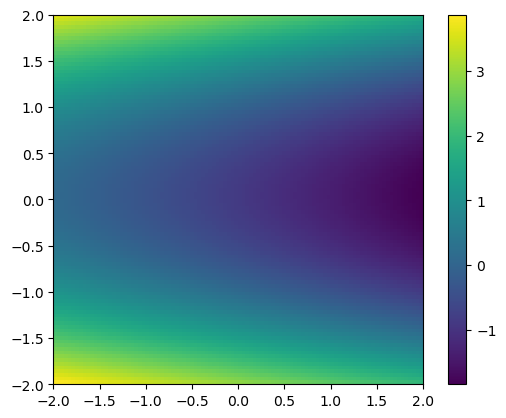

In [53]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[-2,2,-2,2])
plt.colorbar()

In [54]:
scaling

tensor([0.2587], requires_grad=True)

In [55]:
scaling_true

tensor(48.8181, requires_grad=True)

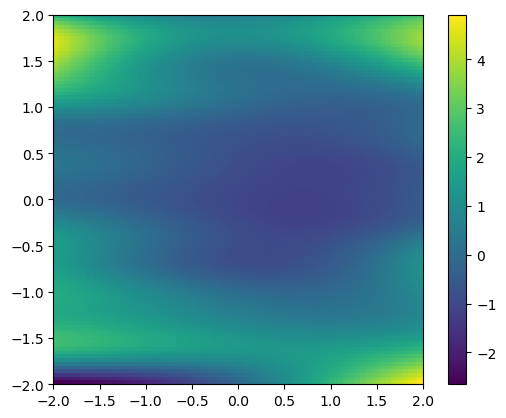

In [56]:
m_p,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale_in,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[-2,2,-2,2])
plt.colorbar()

In [57]:
XL_train.min(axis=0)

torch.return_types.min(
values=tensor([-1.7015, -1.0827], grad_fn=<MinBackward0>),
indices=tensor([149,   0]))

In [58]:
gd = torch.optim.SGD([scaling_true,lengthscale_true], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,XL_true_train,scaling_true,lengthscale_true,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%100 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .00000000000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


tensor(-362.5929, grad_fn=<NegBackward0>)
tensor(-362.1642, grad_fn=<NegBackward0>)
tensor(-363.2425, grad_fn=<NegBackward0>)
tensor(-363.2303, grad_fn=<NegBackward0>)
tensor(-363.4119, grad_fn=<NegBackward0>)
tensor(-362.6311, grad_fn=<NegBackward0>)
tensor(-363.1289, grad_fn=<NegBackward0>)
tensor(-362.7028, grad_fn=<NegBackward0>)
tensor(-363.4241, grad_fn=<NegBackward0>)
tensor(-362.0892, grad_fn=<NegBackward0>)
tensor(-362.4081, grad_fn=<NegBackward0>)
tensor(-362.5173, grad_fn=<NegBackward0>)
tensor(-363.5844, grad_fn=<NegBackward0>)
tensor(-362.4911, grad_fn=<NegBackward0>)
tensor(-363.0336, grad_fn=<NegBackward0>)
tensor(-362.8813, grad_fn=<NegBackward0>)
tensor(-362.7928, grad_fn=<NegBackward0>)
tensor(-363.0578, grad_fn=<NegBackward0>)
tensor(-362.8668, grad_fn=<NegBackward0>)
tensor(-362.9301, grad_fn=<NegBackward0>)
tensor(-362.9391, grad_fn=<NegBackward0>)
tensor(-363.5787, grad_fn=<NegBackward0>)
tensor(-363.1714, grad_fn=<NegBackward0>)
tensor(-362.5673, grad_fn=<NegBack

KeyboardInterrupt: 

## lengthscale=4

In [59]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [60]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in=torch.cat([lengthscale,torch.tensor([4])])


In [61]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
for i in range(1000000):
    lengthscale_in=torch.cat([lengthscale,torch.tensor([4])])
    gd.zero_grad()
    objective = cost(Y,XL_train,scaling,lengthscale_in,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)
    
    if i%1000 ==0:
        XL_test = torch.cat((X_test,torch.repeat_interleave(L,p,dim=0)),axis=1)
        m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling,lengthscale_in,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

tensor(198830.8125, grad_fn=<NegBackward0>) tensor([0.8556], grad_fn=<RsubBackward1>) tensor([0.6263], requires_grad=True)
tensor(139735.7500, grad_fn=<NegBackward0>) tensor([0.8597], grad_fn=<RsubBackward1>) tensor([0.6364], requires_grad=True)
tensor(136040.7031, grad_fn=<NegBackward0>) tensor([0.8636], grad_fn=<RsubBackward1>) tensor([0.6465], requires_grad=True)
tensor(132334.2500, grad_fn=<NegBackward0>) tensor([0.8676], grad_fn=<RsubBackward1>) tensor([0.6566], requires_grad=True)
tensor(128360.5781, grad_fn=<NegBackward0>) tensor([0.8713], grad_fn=<RsubBackward1>) tensor([0.6667], requires_grad=True)
tensor(124533.5156, grad_fn=<NegBackward0>) tensor([0.8759], grad_fn=<RsubBackward1>) tensor([0.6769], requires_grad=True)
tensor(120576.0156, grad_fn=<NegBackward0>) tensor([0.8796], grad_fn=<RsubBackward1>) tensor([0.6869], requires_grad=True)
tensor(116645.3281, grad_fn=<NegBackward0>) tensor([0.8836], grad_fn=<RsubBackward1>) tensor([0.6970], requires_grad=True)
tensor(112660.76

KeyboardInterrupt: 

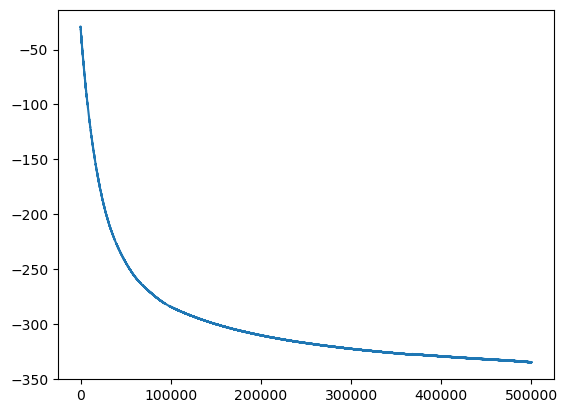

In [89]:
plt.plot(history_gd)

In [63]:
torch.cat(Ls,axis=1)

tensor([[ 0.9465,  0.9465,  0.9464,  ...,  1.3120,  1.3120,  1.3120],
        [-0.0122, -0.0122, -0.0122,  ...,  0.3295,  0.3295,  0.3295],
        [ 0.1803,  0.1803,  0.1803,  ...,  1.3958,  1.3958,  1.3958],
        ...,
        [-2.1800, -2.1800, -2.1800,  ..., -3.2544, -3.2544, -3.2544],
        [-1.5941, -1.5941, -1.5941,  ..., -1.9508, -1.9508, -1.9508],
        [-0.6989, -0.6989, -0.6989,  ...,  0.7406,  0.7406,  0.7406]])

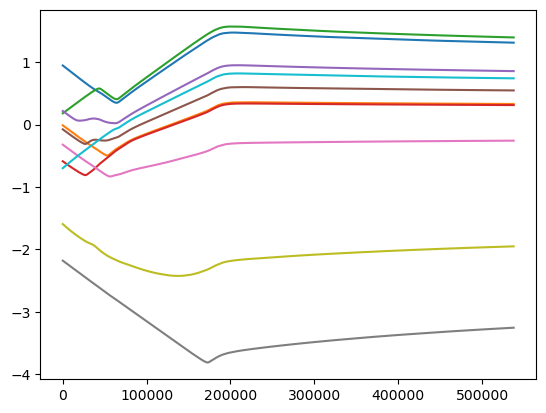

In [64]:
plt.plot(torch.cat(Ls,axis=1).T.detach().numpy())

In [65]:
torch.cat(lengths).shape

torch.Size([537667])

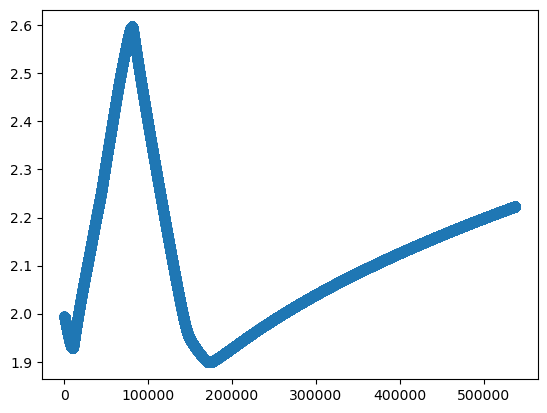

In [66]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

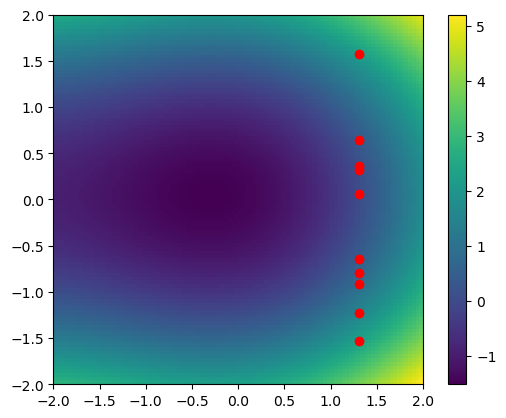

In [67]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[0:10,1].detach().numpy(),XL_train[0:10,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

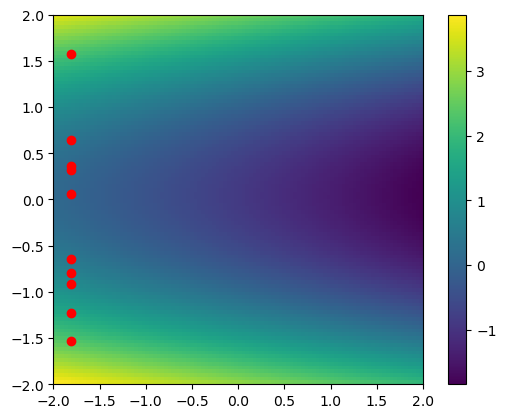

In [68]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[0:10,1].detach().numpy(),XL_true_train[0:10,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

## lengthscale=1

In [115]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [116]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling = (2*torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale = (2*torch.rand(X_train.shape[1])).clone().detach().requires_grad_(True)
lengthscale_in=torch.cat([lengthscale,torch.tensor([4])])


In [117]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
for i in range(1000000):
    lengthscale_in=torch.cat([lengthscale,torch.tensor([1])])
    gd.zero_grad()
    objective = cost(Y,XL_train,scaling,lengthscale_in,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    XL_train = torch.cat((X_train,torch.repeat_interleave(L,p,dim=0)),axis=1)
    
    if i%1000 ==0:
        XL_test = torch.cat((X_test,torch.repeat_interleave(L,p,dim=0)),axis=1)
        m_p,K_p = posterior_theta(Y,XL_test,XL_train,scaling,lengthscale_in,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

tensor(61890.0781, grad_fn=<NegBackward0>) tensor([0.6966], grad_fn=<RsubBackward1>) tensor([1.5933], requires_grad=True)
tensor(113154.4453, grad_fn=<NegBackward0>) tensor([0.7232], grad_fn=<RsubBackward1>) tensor([1.6037], requires_grad=True)
tensor(89296.2969, grad_fn=<NegBackward0>) tensor([0.7700], grad_fn=<RsubBackward1>) tensor([1.6175], requires_grad=True)
tensor(66287.7578, grad_fn=<NegBackward0>) tensor([0.8190], grad_fn=<RsubBackward1>) tensor([1.6302], requires_grad=True)
tensor(47735.3203, grad_fn=<NegBackward0>) tensor([0.8671], grad_fn=<RsubBackward1>) tensor([1.6410], requires_grad=True)
tensor(33354.2109, grad_fn=<NegBackward0>) tensor([0.9082], grad_fn=<RsubBackward1>) tensor([1.6503], requires_grad=True)
tensor(22925.9727, grad_fn=<NegBackward0>) tensor([0.9416], grad_fn=<RsubBackward1>) tensor([1.6589], requires_grad=True)
tensor(15398.4346, grad_fn=<NegBackward0>) tensor([0.9665], grad_fn=<RsubBackward1>) tensor([1.6672], requires_grad=True)
tensor(10196.0107, grad

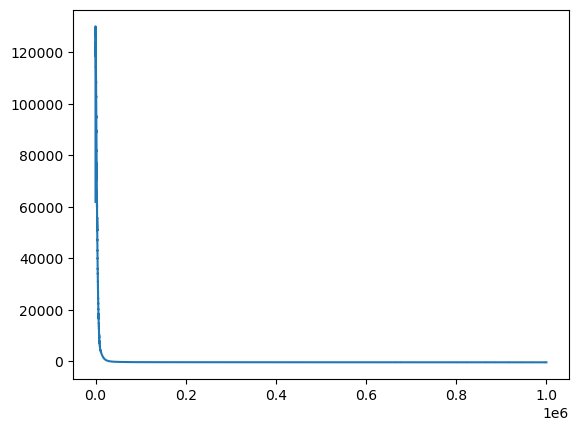

In [118]:
plt.plot(history_gd)

In [119]:
torch.cat(Ls,axis=1)

tensor([[ 0.1137,  0.1137,  0.1137,  ...,  0.1148,  0.1148,  0.1148],
        [ 0.4936,  0.4936,  0.4936,  ...,  1.1190,  1.1190,  1.1190],
        [ 0.5053,  0.5053,  0.5053,  ...,  0.2320,  0.2320,  0.2320],
        ...,
        [-0.9106, -0.9106, -0.9106,  ..., -0.6789, -0.6789, -0.6789],
        [ 0.1033,  0.1033,  0.1033,  ..., -0.2241, -0.2241, -0.2241],
        [-1.4749, -1.4749, -1.4749,  ..., -0.8368, -0.8368, -0.8368]])

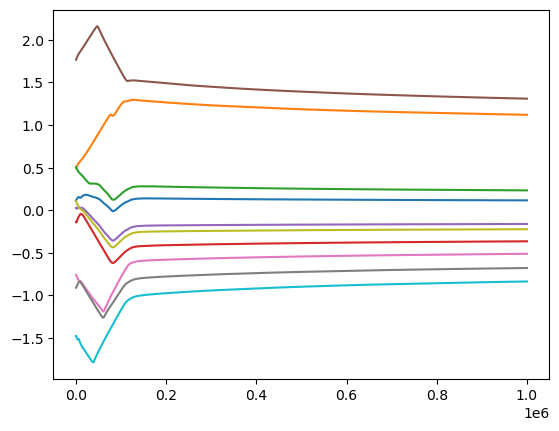

In [120]:
plt.plot(torch.cat(Ls,axis=1).T.detach().numpy())

In [121]:
torch.cat(lengths).shape

torch.Size([1000000])

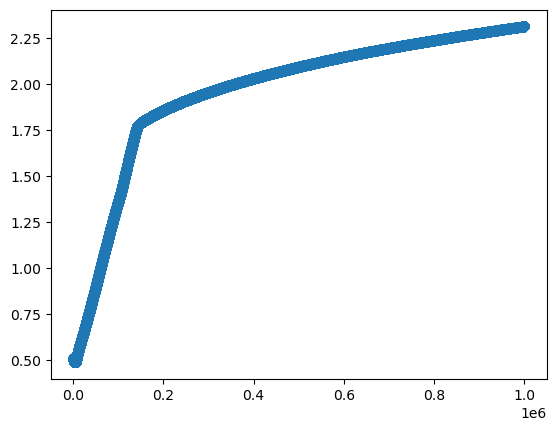

In [122]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

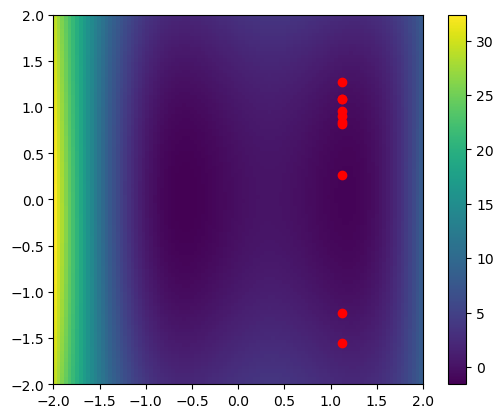

In [123]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[30:40,1].detach().numpy(),XL_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

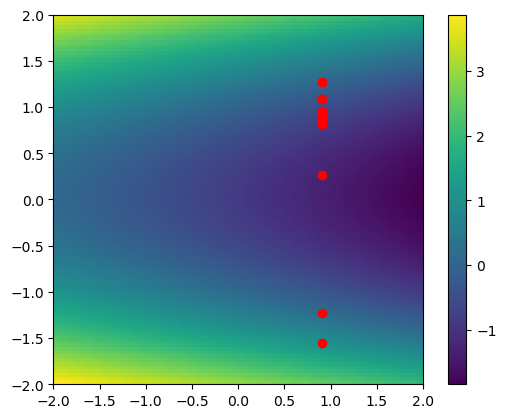

In [124]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

## Can we get to the true values?

In [125]:
history_gd = []
scales=[]
lengths=[]
Ls=[]

In [126]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
scaling = (torch.rand(1)).clone().detach().requires_grad_(True)
lengthscale = torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)

In [127]:
gd = torch.optim.Adam([scaling,lengthscale], lr=1e-5)
for i in range(500000):
    gd.zero_grad()
    objective = cost(Y,XL_true_train,scaling,lengthscale,sigma2,L_dim=1)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    scales.append(scaling.clone().detach())
    lengths.append(lengthscale.clone().detach())
    Ls.append(L.clone().detach())
    
    if i%1000 ==0:
        m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling,lengthscale,sigma2,mean)
        R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
        print(objective,R2,scaling)
        
    #if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000000000000000000000001):
        #print("Convergence achieved in ", i+1, " iterations") 
        #print("-LogL Value: ", objective.item())
        #break

tensor(-195.2220, grad_fn=<NegBackward0>) tensor([0.9993], grad_fn=<RsubBackward1>) tensor([0.3557], requires_grad=True)
tensor(-197.5580, grad_fn=<NegBackward0>) tensor([0.9993], grad_fn=<RsubBackward1>) tensor([0.3656], requires_grad=True)
tensor(-199.7390, grad_fn=<NegBackward0>) tensor([0.9993], grad_fn=<RsubBackward1>) tensor([0.3753], requires_grad=True)
tensor(-201.8290, grad_fn=<NegBackward0>) tensor([0.9993], grad_fn=<RsubBackward1>) tensor([0.3850], requires_grad=True)
tensor(-203.8406, grad_fn=<NegBackward0>) tensor([0.9994], grad_fn=<RsubBackward1>) tensor([0.3946], requires_grad=True)
tensor(-205.7568, grad_fn=<NegBackward0>) tensor([0.9994], grad_fn=<RsubBackward1>) tensor([0.4043], requires_grad=True)
tensor(-207.6321, grad_fn=<NegBackward0>) tensor([0.9994], grad_fn=<RsubBackward1>) tensor([0.4139], requires_grad=True)
tensor(-209.4250, grad_fn=<NegBackward0>) tensor([0.9994], grad_fn=<RsubBackward1>) tensor([0.4235], requires_grad=True)
tensor(-211.1557, grad_fn=<NegBa

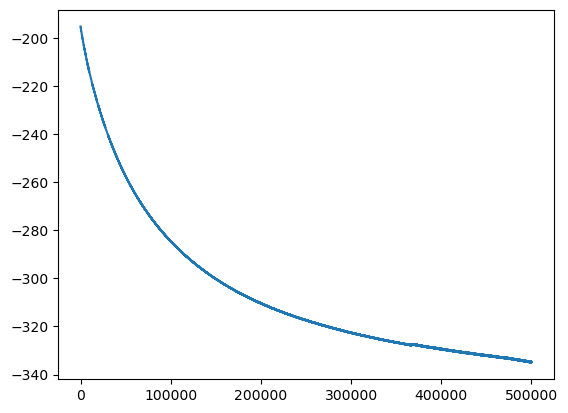

In [128]:
plt.plot(history_gd)

In [129]:
torch.cat(Ls,axis=1)

tensor([[-0.1859, -0.1859, -0.1859,  ..., -0.1859, -0.1859, -0.1859],
        [ 2.5626,  2.5626,  2.5626,  ...,  2.5626,  2.5626,  2.5626],
        [ 0.4768,  0.4768,  0.4768,  ...,  0.4768,  0.4768,  0.4768],
        ...,
        [ 0.1127,  0.1127,  0.1127,  ...,  0.1127,  0.1127,  0.1127],
        [ 1.7407,  1.7407,  1.7407,  ...,  1.7407,  1.7407,  1.7407],
        [-0.9080, -0.9080, -0.9080,  ..., -0.9080, -0.9080, -0.9080]])

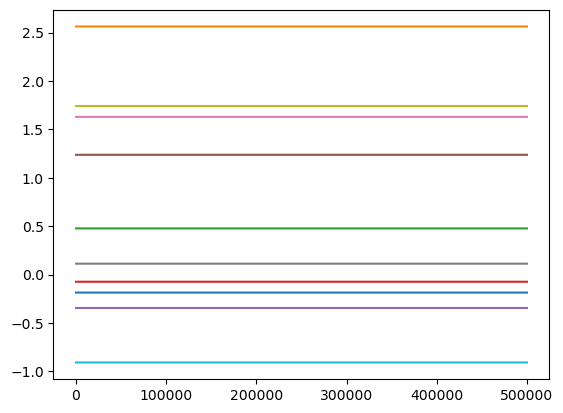

In [130]:
plt.plot(torch.cat(Ls,axis=1).T.detach().numpy())

In [131]:
torch.cat(lengths).shape

torch.Size([1000000])

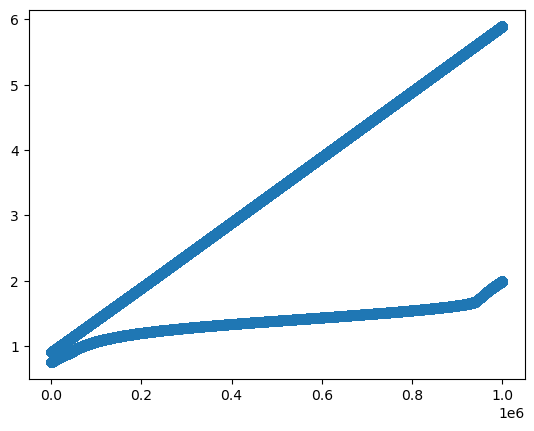

In [132]:
plt.plot(torch.cat(lengths).detach().numpy(),'o')

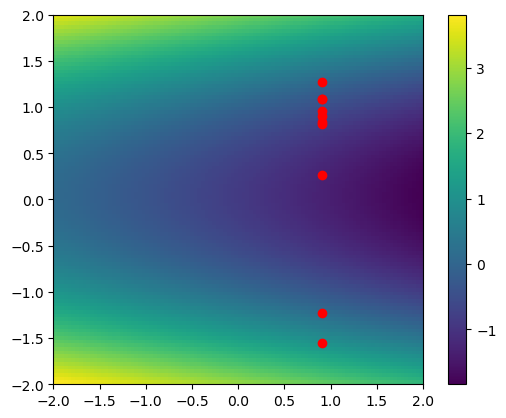

In [133]:
m_p2,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

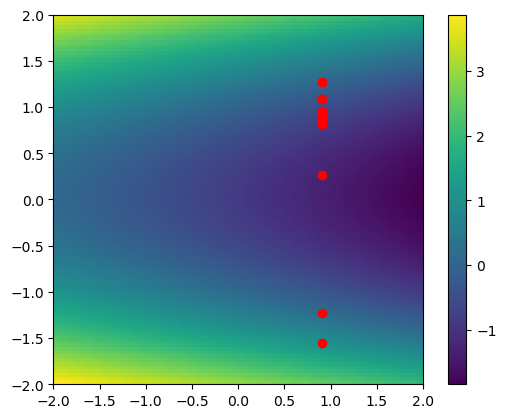

In [134]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[30:40,1].detach().numpy(),XL_true_train[30:40,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

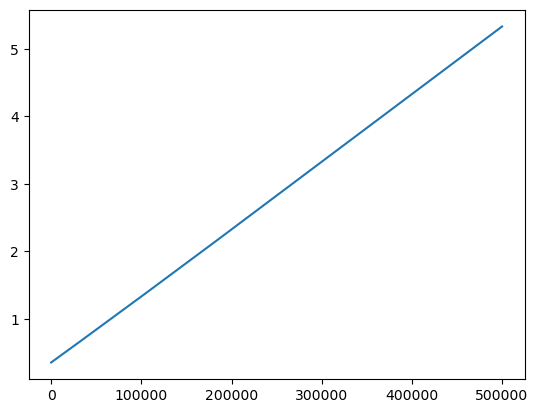

In [135]:
plt.plot(torch.tensor(scales).detach().numpy())

In [178]:
scaling_true

tensor(42.8275, requires_grad=True)

In [179]:
scaling

tensor([5.8656], requires_grad=True)

In [180]:
Y_test.std()

tensor(1.0661)

In [181]:

print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

tensor([0.9989], grad_fn=<RsubBackward1>) tensor([0.3617], grad_fn=<MeanBackward1>) tensor([340.8223])


In [182]:
m_p,K_p = posterior_theta(Y,XL_true_test,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0),(Y_test*Y_std+Y_mean).std(axis=0)**2)

tensor([0.9997], grad_fn=<RsubBackward1>) tensor([0.0968], grad_fn=<MeanBackward1>) tensor([340.8223])


In [183]:
m_p,K_p = posterior_theta(Y,XL_train,XL_train,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0)/(Y*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0),(Y*Y_std+Y_mean).std(axis=0)**2)

tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0040], grad_fn=<MeanBackward1>) tensor([299.8556])


In [184]:
m_p,K_p = posterior_theta(Y,XL_true_train,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0)/(Y*Y_std+Y_mean).std(axis=0)**2
print(R2,((m_p*Y_std+Y_mean-(Y*Y_std+Y_mean))**2).mean(axis=0),(Y*Y_std+Y_mean).std(axis=0)**2)

tensor([1.0000], grad_fn=<RsubBackward1>) tensor([0.0057], grad_fn=<MeanBackward1>) tensor([299.8556])


In [185]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling,lengthscale,sigma2,mean)

In [186]:
XXLL.min(axis=0)

torch.return_types.min(
values=tensor([-2., -2.]),
indices=tensor([0, 0]))

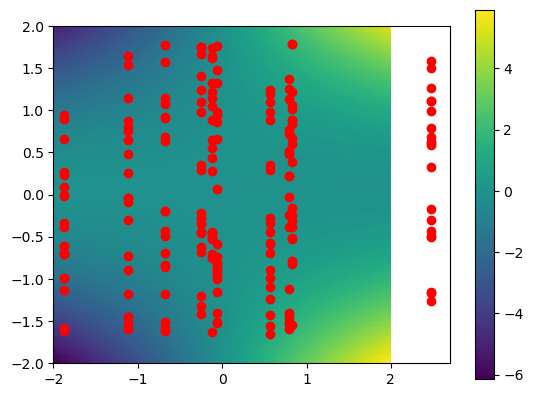

In [191]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_true_train[:,1].detach().numpy(),XL_true_train[:,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,0].detach().numpy(),XL_test[:,1].detach().numpy(),'o',color='b')
plt.colorbar()

In [188]:
XL_train

tensor([[ 1.2569,  0.4618],
        [ 0.7715,  0.4618],
        [ 1.3708,  0.4618],
        [-1.5144,  0.4618],
        [ 0.7179,  0.4618],
        [-1.1211,  0.4618],
        [ 0.2157,  0.4618],
        [-0.2471,  0.4618],
        [ 1.1376,  0.4618],
        [-1.4116,  0.4618],
        [-1.5892,  0.4618],
        [ 0.2145,  0.4618],
        [-1.4603,  0.4618],
        [-1.5370,  0.4618],
        [-0.0284,  0.4618],
        [ 0.4788,  0.4618],
        [-0.3852,  0.4618],
        [ 0.4957,  0.4618],
        [-1.4033,  0.4618],
        [ 0.5193,  0.4618],
        [-0.7904,  1.5386],
        [-1.5415,  1.5386],
        [-0.3078,  1.5386],
        [ 0.8396,  1.5386],
        [ 0.6667,  1.5386],
        [ 1.7857,  1.5386],
        [-0.2436,  1.5386],
        [ 0.3895,  1.5386],
        [ 1.2136,  1.5386],
        [ 1.0583,  1.5386],
        [-0.8219,  1.5386],
        [-0.5234,  1.5386],
        [-0.1550,  1.5386],
        [ 1.0153,  1.5386],
        [ 0.6027,  1.5386],
        [-0.5165,  1

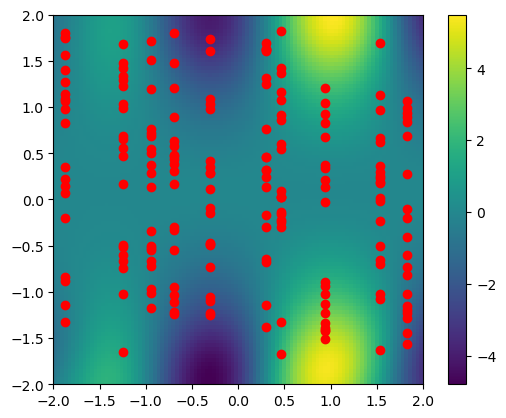

In [192]:



m_p2,K_p = posterior_theta(Y,XXLL,XL_train,scaling,lengthscale,sigma2,mean)
plt.imshow(m_p2.reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.plot(XL_train[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,1].detach().numpy(),XL_test[:,0].detach().numpy(),'o',color='b')
plt.colorbar() 

In [193]:
lengthscale

tensor([0.5896], requires_grad=True)

In [194]:
L

tensor([[ 0.4618],
        [ 1.5386],
        [-0.9403],
        [-1.2526],
        [-0.3025],
        [ 1.8226],
        [ 0.3003],
        [-0.6969],
        [-1.8704],
        [ 0.9391]], requires_grad=True)

In [195]:
scaling

tensor([5.8656], requires_grad=True)

In [196]:
lengthscale_true

tensor([[1.7884, 3.6843]], requires_grad=True)

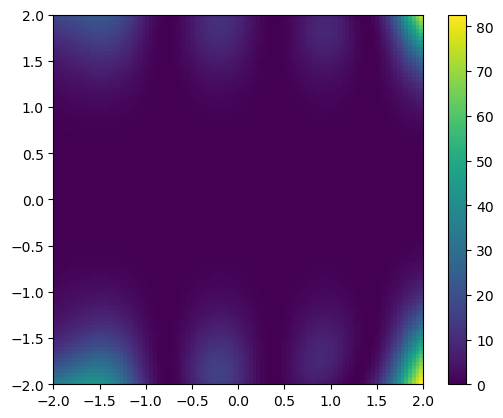

In [197]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow((m_p.reshape(100,100).detach().numpy()-m_p2.reshape(100,100).detach().numpy())**2,origin='lower',extent=[lmin,lmax,xmin,xmax])
#plt.plot(XL_train[:,0].detach().numpy(),XL_train[:,1].detach().numpy(),'o',color='r')
#plt.plot(XL_test[:,0].detach().numpy(),XL_test[:,1].detach().numpy(),'o',color='b')
plt.colorbar()

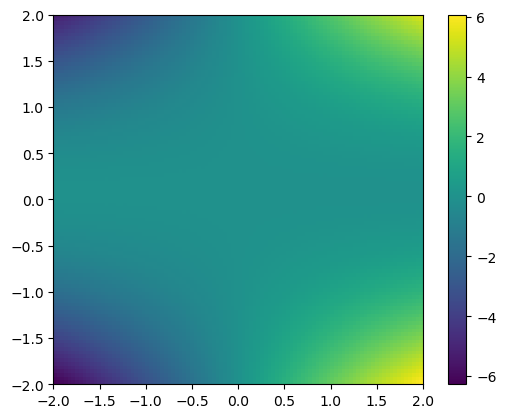

In [198]:
plt.imshow(emulator.predict(XXLL).reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.colorbar()

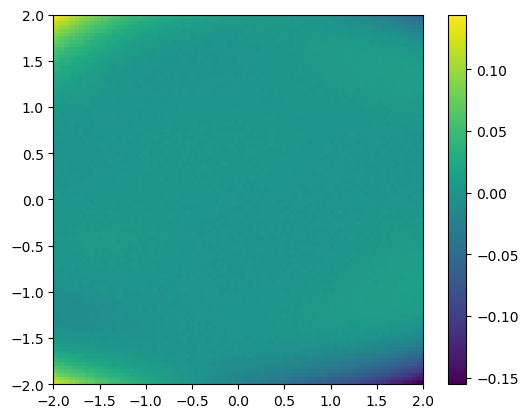

In [199]:
m_p,K_p = posterior_theta(Y,XXLL,XL_true_train,scaling_true,lengthscale_true,sigma2,mean)
plt.imshow(m_p.reshape(100,100).detach().numpy()-emulator.predict(XXLL).reshape(100,100).detach().numpy(),origin='lower',extent=[lmin,lmax,xmin,xmax])
plt.colorbar()

In [200]:
L_true

tensor([[ 0.7970],
        [ 0.8270],
        [-0.2529],
        [ 0.5677],
        [-1.8781],
        [-0.6771],
        [-0.0615],
        [-1.1163],
        [-0.1261],
        [ 2.4803]])

In [201]:
L

tensor([[ 0.4618],
        [ 1.5386],
        [-0.9403],
        [-1.2526],
        [-0.3025],
        [ 1.8226],
        [ 0.3003],
        [-0.6969],
        [-1.8704],
        [ 0.9391]], requires_grad=True)

In [202]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

tensor([0.9922], grad_fn=<RsubBackward1>) tensor([0.8307], grad_fn=<MeanBackward1>) tensor([105.8816])
tensor([0.9931], grad_fn=<RsubBackward1>) tensor([0.5561], grad_fn=<MeanBackward1>) tensor([80.8055])
tensor([0.9997], grad_fn=<RsubBackward1>) tensor([0.0015], grad_fn=<MeanBackward1>) tensor([5.4569])
tensor([0.9914], grad_fn=<RsubBackward1>) tensor([0.3170], grad_fn=<MeanBackward1>) tensor([36.8963])
tensor([0.9989], grad_fn=<RsubBackward1>) tensor([0.4579], grad_fn=<MeanBackward1>) tensor([403.2801])
tensor([0.9999], grad_fn=<RsubBackward1>) tensor([0.0028], grad_fn=<MeanBackward1>) tensor([44.3532])
tensor([0.9956], grad_fn=<RsubBackward1>) tensor([0.0029], grad_fn=<MeanBackward1>) tensor([0.6433])
tensor([0.9972], grad_fn=<RsubBackward1>) tensor([0.3961], grad_fn=<MeanBackward1>) tensor([141.2536])
tensor([0.7173], grad_fn=<RsubBackward1>) tensor([0.6960], grad_fn=<MeanBackward1>) tensor([2.4617])
tensor([0.9995], grad_fn=<RsubBackward1>) tensor([0.3627], grad_fn=<MeanBackward1>

In [203]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,XL_test[i*p:(i+1)*p],XL_train,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p-(Y_test[i*p:(i+1)*p,:]))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]).std(axis=0)**2
    print(R2,((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0),(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2)

tensor([0.9922], grad_fn=<RsubBackward1>) tensor([0.8307], grad_fn=<MeanBackward1>) tensor([105.8816])
tensor([0.9931], grad_fn=<RsubBackward1>) tensor([0.5561], grad_fn=<MeanBackward1>) tensor([80.8055])
tensor([0.9997], grad_fn=<RsubBackward1>) tensor([0.0015], grad_fn=<MeanBackward1>) tensor([5.4569])
tensor([0.9914], grad_fn=<RsubBackward1>) tensor([0.3170], grad_fn=<MeanBackward1>) tensor([36.8963])
tensor([0.9989], grad_fn=<RsubBackward1>) tensor([0.4579], grad_fn=<MeanBackward1>) tensor([403.2801])
tensor([0.9999], grad_fn=<RsubBackward1>) tensor([0.0028], grad_fn=<MeanBackward1>) tensor([44.3532])
tensor([0.9956], grad_fn=<RsubBackward1>) tensor([0.0029], grad_fn=<MeanBackward1>) tensor([0.6433])
tensor([0.9972], grad_fn=<RsubBackward1>) tensor([0.3961], grad_fn=<MeanBackward1>) tensor([141.2536])
tensor([0.7173], grad_fn=<RsubBackward1>) tensor([0.6960], grad_fn=<MeanBackward1>) tensor([2.4617])
tensor([0.9995], grad_fn=<RsubBackward1>) tensor([0.3627], grad_fn=<MeanBackward1>

### Test 2

In [73]:
N = 10 #number of systems
p = 20 #observations per system
alpha=10
beta=-7
zeta=5

In [74]:
L_true=torch.FloatTensor(N, 2).uniform_(-1, 1)

In [75]:
L_true[0]

tensor([-0.7074, -0.7831])

In [76]:
multivariate_ll(L_true,0,torch.eye(N),K_inv=None)

tensor(-21.1272)

In [77]:

import scipy
np.sum(scipy.stats.multivariate_normal.logpdf(L_true.T.detach().numpy(),cov=np.eye(N)))

-21.12724585763744

In [78]:
X_train=torch.torch.FloatTensor(N*p, 2).uniform_(-1, 1)
X_test=torch.torch.FloatTensor(N*p, 2).uniform_(-1, 1)

In [79]:
L_true[[0]][0]

tensor([-0.7074, -0.7831])

In [80]:
def true_func(X,L,alpha,beta,zeta):
    tf = alpha*X[:,[0]]*X[:,[ 0]]*L[:,0]+beta*L[:,1]*X[:,[ 1]]+zeta+torch.normal(0,0.01*torch.ones(X.shape[0],1))
    return tf

In [81]:
y=[]
y_test = []
for i in range(N):
    y.append(true_func(X_train[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))
    y_test.append(true_func(X_test[i*p:(i+1)*p],L_true[[i]],alpha,beta,zeta))

In [82]:
Y=torch.cat(y)
Y_test=torch.cat(y_test)

In [83]:
Y.shape

torch.Size([200, 1])

In [84]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X_train.mean()
X_std =X_train.std()

X_train = (X_train-X_mean)/X_std
X_test = (X_test-X_mean)/X_std

In [85]:
X_train[i*p:(i+1)*p,0].shape

torch.Size([20])

In [86]:
emulators=[]
for i in range(N):
    emulators.append(GPE.ensemble(X_train[i*p:(i+1)*p,:],Y[i*p:(i+1)*p],mean_func='zero'))

0
0
0
0
0
0
0
0
0
0


In [87]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])))

tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9995], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)


In [88]:
Y=(Y-Y_mean)/Y_std
Y_test=(Y_test-Y_mean)/Y_std

In [89]:
def cost(y,X,L,scaling,lengthscale,sigma2,p,mean=0):
    

    K=rbf(X,L,X,L,scaling,lengthscale,p,p)+sigma2*torch.eye(X.shape[0])
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(y,mean,K) + multivariate_ll(L,0,torch.eye(L.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    return -c

In [90]:
L = torch.rand(L_true.shape[0],L_true.shape[1]).clone().detach().requires_grad_(True)

In [126]:
L =torch.normal(0,torch.ones(L_true.shape[0],L_true.shape[1])).clone().detach().requires_grad_(True)
#L =L_true.clone().detach().requires_grad_(True)
scaling = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale = torch.rand(X_train.shape[1]+L_true.shape[1]).clone().detach().requires_grad_(True)
sigma2 = torch.tensor([0.000001]).clone().detach().requires_grad_(True)
mean = torch.rand(1).clone().detach().requires_grad_(True)
mean=0

In [127]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L[[i]],p,X_train[i*p:(i+1)*p],L[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

tensor([0.8305], grad_fn=<RsubBackward1>)
tensor([0.8181], grad_fn=<RsubBackward1>)
tensor([0.3216], grad_fn=<RsubBackward1>)
tensor([0.2750], grad_fn=<RsubBackward1>)
tensor([0.7624], grad_fn=<RsubBackward1>)
tensor([0.8125], grad_fn=<RsubBackward1>)
tensor([0.8341], grad_fn=<RsubBackward1>)
tensor([0.6715], grad_fn=<RsubBackward1>)
tensor([0.8570], grad_fn=<RsubBackward1>)
tensor([0.8343], grad_fn=<RsubBackward1>)


In [128]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p)

tensor(2118.8745, grad_fn=<NegBackward0>)

In [129]:
#plt.imshow(rbf(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

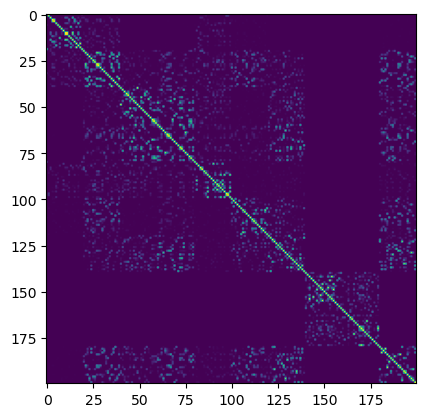

In [130]:
plt.imshow(rbf(X_train,L,X_train,L,scaling,lengthscale,p,p).detach().numpy())

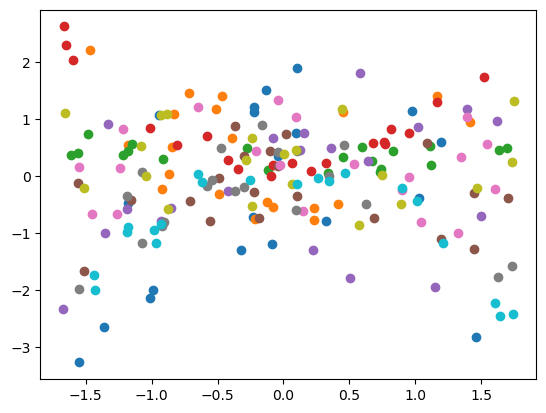

In [131]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0],Y[i*p:(i+1)*p],'o')

In [134]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

tensor(260.6838, grad_fn=<NegBackward0>)

In [135]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,X_train,L,scaling,lengthscale,sigma2,p)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%1000 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .0000000000000000000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


tensor(1361.8494, grad_fn=<NegBackward0>)
tensor(1371.1677, grad_fn=<NegBackward0>)
tensor(1389.7579, grad_fn=<NegBackward0>)
tensor(1414.1477, grad_fn=<NegBackward0>)
tensor(1439.3892, grad_fn=<NegBackward0>)
tensor(1460.9512, grad_fn=<NegBackward0>)
tensor(1481.2285, grad_fn=<NegBackward0>)
tensor(1507.2640, grad_fn=<NegBackward0>)
tensor(1542.0706, grad_fn=<NegBackward0>)
tensor(1586.3137, grad_fn=<NegBackward0>)


KeyboardInterrupt: 

In [136]:
L_true

tensor([[-0.7074, -0.7831],
        [ 0.5125, -0.5125],
        [ 0.1357, -0.1532],
        [ 0.7437, -0.1057],
        [-0.2861,  0.9220],
        [-0.3917, -0.4165],
        [-0.1319, -0.5514],
        [-0.6304,  0.3628],
        [ 0.0858, -0.4888],
        [-0.9311, -0.1709]])

In [137]:
L

tensor([[ 1.3523e+00,  1.8315e+00],
        [ 7.3444e-01,  7.1754e-01],
        [ 1.1710e+00, -1.8263e-01],
        [ 8.3194e-01, -5.0654e-04],
        [ 1.6419e+00,  5.7777e-01],
        [ 1.9055e-02,  6.6111e-01],
        [ 3.5347e-01, -6.2558e-24],
        [-1.3014e+00, -4.9054e-01],
        [-9.7378e-01, -1.4241e+00],
        [ 3.8892e-01,  1.0303e-01]], requires_grad=True)

In [138]:
lengthscale


tensor([0.2864, 0.5286, 0.7202, 0.9574], requires_grad=True)

In [139]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p,mean)

tensor(170.2065, grad_fn=<NegBackward0>)

In [140]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p,mean)

tensor(1624.4268, grad_fn=<NegBackward0>)

In [141]:
mean

0

In [142]:
m_p,K_p = posterior_theta(Y,X_test,L,p,X_train,L,p,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2)

tensor([0.1907], grad_fn=<RsubBackward1>)


In [143]:
X_test[i*p:(i+1)*p:,].shape

torch.Size([0, 2])

In [147]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,X_test[i*p:(i+1)*p],L[[i]],p,X_train,L,p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

tensor([0.6795], grad_fn=<RsubBackward1>)
tensor([-0.2926], grad_fn=<RsubBackward1>)
tensor([-8.1183], grad_fn=<RsubBackward1>)
tensor([-1.3128], grad_fn=<RsubBackward1>)
tensor([0.6764], grad_fn=<RsubBackward1>)
tensor([-2.3748], grad_fn=<RsubBackward1>)
tensor([-1.2567], grad_fn=<RsubBackward1>)
tensor([0.4995], grad_fn=<RsubBackward1>)
tensor([0.7166], grad_fn=<RsubBackward1>)
tensor([-1.3470], grad_fn=<RsubBackward1>)


In [148]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y,X_test[i*p:(i+1)*p],L_true[[i]],p,X_train,L_true,p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(R2)

tensor([0.9586], grad_fn=<RsubBackward1>)
tensor([0.9145], grad_fn=<RsubBackward1>)
tensor([0.8353], grad_fn=<RsubBackward1>)
tensor([0.5914], grad_fn=<RsubBackward1>)
tensor([0.8070], grad_fn=<RsubBackward1>)
tensor([0.9783], grad_fn=<RsubBackward1>)
tensor([0.9675], grad_fn=<RsubBackward1>)
tensor([0.9389], grad_fn=<RsubBackward1>)
tensor([0.9657], grad_fn=<RsubBackward1>)
tensor([0.9753], grad_fn=<RsubBackward1>)


In [149]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])*Y_std+Y_mean))


tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9995], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)


In [110]:
cost(Y,X_train,L,scaling,lengthscale,sigma2,p)

tensor(203.7760, grad_fn=<NegBackward0>)

In [111]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

tensor(143.4147, grad_fn=<NegBackward0>)

In [112]:
#plt.imshow(rbf(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

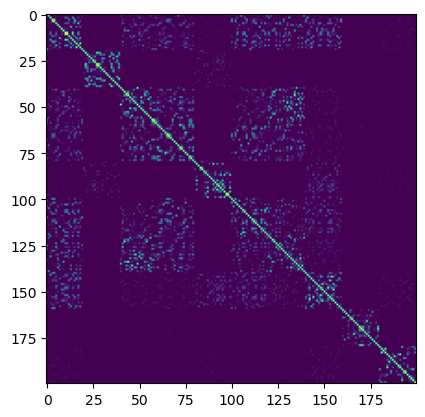

In [113]:
plt.imshow(rbf(X_train,L,X_train,L,scaling,lengthscale,p,p).detach().numpy())

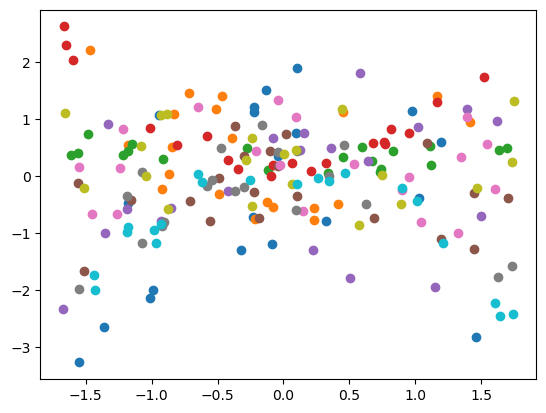

In [114]:
for i in range(N):
    plt.plot(X_train[i*p:(i+1)*p,0],Y[i*p:(i+1)*p],'o')

In [117]:
cost(Y,X_train,L_true,scaling,lengthscale,sigma2,p)

tensor(142.9985, grad_fn=<NegBackward0>)

In [118]:
gd = torch.optim.Adam([L,scaling,lengthscale], lr=1e-5)
history_gd = []

for i in range(100000):
    gd.zero_grad()
    objective = cost(Y,X_train,L,scaling,lengthscale,sigma2,p)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%1000 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .00000001):
        print("Convergence achieved in ", i+1, " iterations") 
        print("-LogL Value: ", objective.item())
        break


tensor(203.5854, grad_fn=<NegBackward0>)
Convergence achieved in  408  iterations
-LogL Value:  203.51806640625


In [119]:
L_true

tensor([[-0.7074, -0.7831],
        [ 0.5125, -0.5125],
        [ 0.1357, -0.1532],
        [ 0.7437, -0.1057],
        [-0.2861,  0.9220],
        [-0.3917, -0.4165],
        [-0.1319, -0.5514],
        [-0.6304,  0.3628],
        [ 0.0858, -0.4888],
        [-0.9311, -0.1709]])

In [120]:
L

tensor([[-2.4090e-01,  3.9696e-01],
        [-2.0466e+00, -1.0231e+00],
        [ 1.6661e-01,  8.8407e-01],
        [ 4.0846e-01,  3.1580e-01],
        [-1.2752e+00, -4.1741e-01],
        [ 6.9629e-02, -2.1784e-02],
        [ 6.6637e-02,  8.1267e-01],
        [-5.9537e-01, -9.4434e-42],
        [ 1.4441e+00,  1.2540e+00],
        [-1.2523e+00,  1.1383e+00]], requires_grad=True)

In [121]:
m_p,K_p = posterior_theta(Y,X_test,L,p,X_train,L,p,scaling,lengthscale,sigma2,mean)
R2=1-((m_p*Y_std+Y_mean-(Y_test*Y_std+Y_mean))**2).mean(axis=0)/(Y_test*Y_std+Y_mean).std(axis=0)**2
print(R2)

tensor([0.8650], grad_fn=<RsubBackward1>)


In [122]:
X_test[i*p:(i+1)*p:,].shape

torch.Size([0, 2])

In [123]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L[[i]],p,X_train[i*p:(i+1)*p],L[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(m_p[0],R2)

tensor([-2.4634], grad_fn=<SelectBackward0>) tensor([0.8523], grad_fn=<RsubBackward1>)
tensor([0.5221], grad_fn=<SelectBackward0>) tensor([0.8577], grad_fn=<RsubBackward1>)
tensor([0.3089], grad_fn=<SelectBackward0>) tensor([0.3686], grad_fn=<RsubBackward1>)
tensor([0.2331], grad_fn=<SelectBackward0>) tensor([0.3527], grad_fn=<RsubBackward1>)
tensor([0.1062], grad_fn=<SelectBackward0>) tensor([0.7705], grad_fn=<RsubBackward1>)
tensor([-0.4096], grad_fn=<SelectBackward0>) tensor([0.8718], grad_fn=<RsubBackward1>)
tensor([-0.4247], grad_fn=<SelectBackward0>) tensor([0.8433], grad_fn=<RsubBackward1>)
tensor([0.0158], grad_fn=<SelectBackward0>) tensor([0.7258], grad_fn=<RsubBackward1>)
tensor([0.5134], grad_fn=<SelectBackward0>) tensor([0.8812], grad_fn=<RsubBackward1>)
tensor([-0.1249], grad_fn=<SelectBackward0>) tensor([0.8605], grad_fn=<RsubBackward1>)


In [124]:
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(Y[i*p:(i+1)*p],X_test[i*p:(i+1)*p],L_true[[i]],p,X_train[i*p:(i+1)*p],L_true[[i]],p,scaling,lengthscale,sigma2,mean)
    R2=1-((m_p*Y_std+Y_mean-(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean))**2).mean(axis=0)/(Y_test[i*p:(i+1)*p,:]*Y_std+Y_mean).std(axis=0)**2
    print(m_p[0],R2)

tensor([-2.4634], grad_fn=<SelectBackward0>) tensor([0.8523], grad_fn=<RsubBackward1>)
tensor([0.5221], grad_fn=<SelectBackward0>) tensor([0.8577], grad_fn=<RsubBackward1>)
tensor([0.3089], grad_fn=<SelectBackward0>) tensor([0.3686], grad_fn=<RsubBackward1>)
tensor([0.2331], grad_fn=<SelectBackward0>) tensor([0.3527], grad_fn=<RsubBackward1>)
tensor([0.1062], grad_fn=<SelectBackward0>) tensor([0.7705], grad_fn=<RsubBackward1>)
tensor([-0.4096], grad_fn=<SelectBackward0>) tensor([0.8718], grad_fn=<RsubBackward1>)
tensor([-0.4247], grad_fn=<SelectBackward0>) tensor([0.8433], grad_fn=<RsubBackward1>)
tensor([0.0158], grad_fn=<SelectBackward0>) tensor([0.7258], grad_fn=<RsubBackward1>)
tensor([0.5134], grad_fn=<SelectBackward0>) tensor([0.8812], grad_fn=<RsubBackward1>)
tensor([-0.1249], grad_fn=<SelectBackward0>) tensor([0.8605], grad_fn=<RsubBackward1>)


In [125]:
for i in range(N):
    print(emulators[i].R2(X_test[i*p:(i+1)*p,:],(Y_test[i*p:(i+1)*p])*Y_std+Y_mean))


tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9995], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([1.0000], grad_fn=<RsubBackward1>)
tensor([0.9999], grad_fn=<RsubBackward1>)


In [885]:
p_new = 20
X_new=torch.torch.FloatTensor(p_new, 1).uniform_(-1, 1)
L_new =torch.normal(0,torch.ones(1,L_true.shape[1]))
#L_new=L_true[[1]]
Y_new=true_func(X_new,L_new,alpha,beta,zeta)

Y_new_mean = Y_new.mean()
Y_new_std = Y_new.std()

Y_new = (Y_new-Y_mean)/Y_std

IndexError: index 1 is out of bounds for dimension 0 with size 1

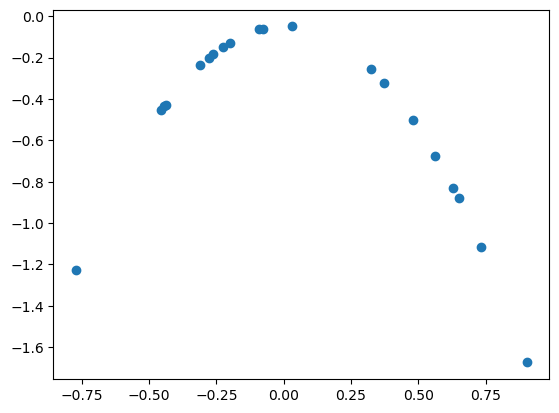

In [826]:
plt.plot(X_new[:,0].detach().numpy(),Y_new.detach().numpy(),'o')

In [827]:
def cf_cost(Y_new,X_new,L_new,Y_train,X_train,L_train,scaling,lengthscale,sigma2,p_train,p_new,mean):
    
    
    mean_p,K_p = posterior_theta(Y_train,X_new,L_new,p_new,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean)
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(Y_new,mean_p,K_p)  + multivariate_ll(L_new,0,torch.eye(L_new.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    #print(multivariate_ll(Y_new,mean_p,K_p))
    #print(multivariate_ll(L_new,0,torch.eye(L_new.shape[0])))
    return -c

In [828]:
cf_cost(Y_new,X_new,L_new,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 8 is not positive-definite).

In [829]:
mean_p,K_p = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

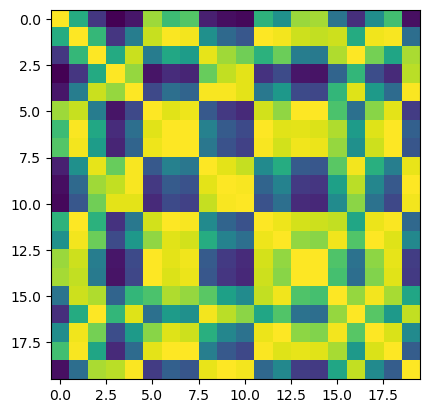

In [830]:
plt.imshow(K_p.detach().numpy())

In [831]:
mean_p

tensor([[-1.0538],
        [-0.6854],
        [-0.7296],
        [-1.2061],
        [-0.8658],
        [-0.7889],
        [-0.7050],
        [-0.7228],
        [-0.8110],
        [-0.9355],
        [-1.0138],
        [-0.6922],
        [-0.6641],
        [-0.7844],
        [-0.7954],
        [-0.6598],
        [-0.7523],
        [-0.6627],
        [-0.7097],
        [-0.9175]], grad_fn=<AddBackward0>)

In [832]:
Y_new

tensor([[-1.2281],
        [-0.1283],
        [-0.2524],
        [-1.6743],
        [-0.6744],
        [-0.4333],
        [-0.1800],
        [-0.2379],
        [-0.5034],
        [-0.8810],
        [-1.1181],
        [-0.1465],
        [-0.0624],
        [-0.4290],
        [-0.4517],
        [-0.0491],
        [-0.3216],
        [-0.0614],
        [-0.1994],
        [-0.8310]])

In [833]:
L_cf =torch.normal(0,torch.ones(1,L_true.shape[1])).clone().detach().requires_grad_(True)
#L_cf = (L[[1]]).clone().detach().requires_grad_(True)

In [834]:
cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 8 is not positive-definite).

In [835]:

cf = torch.optim.Adam([L_cf], lr=1e-5)
history_cf = []

for i in range(100000):
    cf.zero_grad()
    objective = cf_cost(Y_new,X_new,L_cf,Y,X_train,L,scaling,lengthscale,sigma2,p,p_new,mean)
    objective.backward()
    cf.step()
    history_cf.append(objective.item())
    if i%1000 ==0:
        m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)
        print(1-(((m_new-Y_new)**2).mean()/Y_new.std()**2),objective)

    if (i>1) and (np.abs(history_cf[-1] - history_cf[-2]) < .00000000001):
        print("Convergence achieved in ", i+1, " iterations")
        print("-LogL Value: ", objective.item())
        break


_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 8 is not positive-definite).

In [836]:
L_cf

tensor([[-0.5380, -0.9286]], requires_grad=True)

In [837]:
L[[1]]

tensor([[-0.5275, -0.8120]], grad_fn=<IndexBackward0>)

In [838]:
m_new, K_new = posterior_theta(Y,X_new,L_cf,p_new,X_train,L,p,scaling,lengthscale,sigma2,mean)

In [839]:
K_new.detach().numpy()

array([[0.05493431, 0.03440969, 0.00980024, 0.00098122, 0.00426849,
        0.04708742, 0.03794344, 0.04049824, 0.00577209, 0.00302229,
        0.00212663, 0.03575496, 0.028232  , 0.04673599, 0.0475698 ,
        0.02173136, 0.00834123, 0.0275145 , 0.03867809, 0.00329295],
       [0.03440936, 0.05493133, 0.03697355, 0.00950846, 0.02378181,
        0.05045633, 0.05461751, 0.05398439, 0.02815794, 0.01941824,
        0.01566038, 0.05488627, 0.05398266, 0.05072992, 0.05006085,
        0.050813  , 0.03415923, 0.0537474 , 0.05447207, 0.02043849],
       [0.00980012, 0.03697361, 0.05493157, 0.03386973, 0.05061994,
        0.02353843, 0.0334243 , 0.03078316, 0.05301665, 0.04715441,
        0.04315366, 0.03563519, 0.04289778, 0.02394836, 0.02296908,
        0.04859369, 0.05473362, 0.04355918, 0.03267153, 0.04806991],
       [0.00098129, 0.00950839, 0.03387015, 0.05495702, 0.04645292,
        0.00404469, 0.00773908, 0.00659403, 0.04247619, 0.05007432,
        0.05271445, 0.00880689, 0.01325207, 0

In [840]:
multivariate_ll(Y_new,m_new, K_new) + multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 8 is not positive-definite).

In [841]:
multivariate_ll(Y_new,m_new, K_new) 

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 8 is not positive-definite).

In [842]:
multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

tensor(-2.4138, grad_fn=<SubBackward0>)

In [843]:
1-(((m_new-Y_new)**2).mean())/Y_new.std()

tensor(0.7937, grad_fn=<RsubBackward1>)

In [844]:
m_new

tensor([[-1.0912],
        [ 0.2402],
        [ 0.0884],
        [-1.6352],
        [-0.4198],
        [-0.1359],
        [ 0.1691],
        [ 0.1042],
        [-0.2140],
        [-0.6800],
        [-0.9662],
        [ 0.2154],
        [ 0.3186],
        [-0.1194],
        [-0.1594],
        [ 0.3366],
        [ 0.0052],
        [ 0.3240],
        [ 0.1517],
        [-0.6132]], grad_fn=<AddBackward0>)

In [845]:
Y_new

tensor([[-1.2281],
        [-0.1283],
        [-0.2524],
        [-1.6743],
        [-0.6744],
        [-0.4333],
        [-0.1800],
        [-0.2379],
        [-0.5034],
        [-0.8810],
        [-1.1181],
        [-0.1465],
        [-0.0624],
        [-0.4290],
        [-0.4517],
        [-0.0491],
        [-0.3216],
        [-0.0614],
        [-0.1994],
        [-0.8310]])

In [698]:
mean

0